# Makemore - Activations & Gradients, BatchNorm

## Imports

In [5]:
import torch 
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt 

%matplotlib inline
#%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [6]:
SEED = 2147483647

## Dataset

In [7]:
# reading the dataset 
words = open('name.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
# Look up for characters
chars = sorted(set(''.join(words)))
stoi = {s : i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()} 

# Dictornary key, value and in enumerate index, value (column_names, values)

In [9]:
# Dataset 
def build_dataset(words):
    block_size = 3
    context = []
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
            

In [10]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Model

### MLP revisted 

In [ ]:
n_embb = 10  # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer
vocab_size = len(itos) 
block_size = 3

g = torch.Generator().manual_seed(SEED)
C = torch.randn(size=(vocab_size, n_embb),              generator=g) #
W1 = torch.randn(size=(block_size * n_embb, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                              generator=g)
W2 = torch.randn(size=(n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                            generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


In [ ]:
def train(max_steps, batch_size, lossi, g):
    for i in range(max_steps):

        # min batch 
        ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # first layer 
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)

        # hidden layer 
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)

        # third layer
        logits = h @ W2 + b2
        
        # loss 
        loss = F.cross_entropy(logits, Yb)

        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
        
        # stats
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            
        lossi.append(loss.log10().item())


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(SEED)

%time train(max_steps, batch_size, lossi, g)


      0/ 200000: 27.1911
  10000/ 200000: 2.2061
  20000/ 200000: 2.4354
  30000/ 200000: 2.4549
  40000/ 200000: 2.1549
  50000/ 200000: 2.5022
  60000/ 200000: 2.1099
  70000/ 200000: 2.2633
  80000/ 200000: 2.6464
  90000/ 200000: 1.9474
 100000/ 200000: 2.3580
 110000/ 200000: 2.1949
 120000/ 200000: 2.1472
 130000/ 200000: 1.7711
 140000/ 200000: 2.2109
 150000/ 200000: 2.3094
 160000/ 200000: 2.1037
 170000/ 200000: 1.7047
 180000/ 200000: 2.5600
 190000/ 200000: 2.2778
CPU times: user 4min 25s, sys: 1.22 s, total: 4min 27s
Wall time: 2min 13s


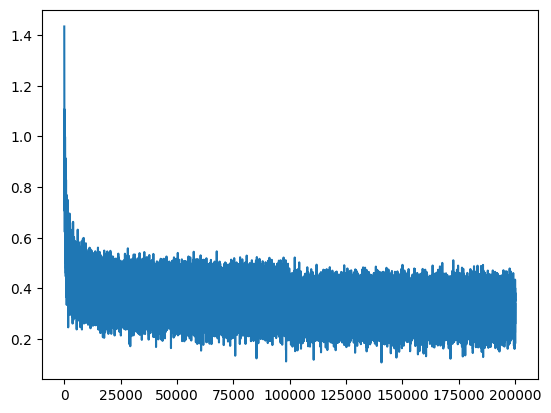

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': [Xtr, Ytr],
        'dev' : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 2.1255719661712646
dev 2.1697864532470703
test 2.164987325668335


In [ ]:
# Sampling 

g = torch.Generator().manual_seed(SEED + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, 1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(itos[c] for c in out))



mora.
mayah.
see.
mad.
ryla.
rethrettadrie.
razered.
eliigh.
parelle.
elissopharleit.
korvara.
noshubergah.
mies.
jacer.
jeniquettochuz.
zayveer.
yarue.
ehs.
kaysh.
skylan.


### Fixing 

In [7]:
# Intially when we are running our model we are getting a loss of 27 which way too high 
# but at the intial state the probability for each of the character in our vocab should have equal probabality as every character will be equally likely 
# but when we are intializing neural network is creating probabilities that are almost up some character have very high probability and some have very less
# so our neural network is very confidently wrong that make it record very high loss 

# A 4-dimenssional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) 
prob = torch.softmax(logits, dim=0)
loss = -prob[2].log()

# here all the probabilities are same and so the loss will be the same it doesn't matter which is the true label 
# but if we change the logits and make them not equally likely then the loss will change if we assign a higher value 
# to our true label then loss will be low because we will be assign high probability for the true label and vice versa

logits_1 = torch.tensor([0.0, 0.0, 5.0, 0.0]) 
logits_2 = torch.tensor([0.0, 5.0, .0, 0.0]) 
prob_1 = torch.softmax(logits_1, dim=0)
loss_1 = -prob_1[2].log()
prob_2 = torch.softmax(logits_2, dim=0)
loss_2 = -prob_2[2].log()
prob, loss, prob_1, loss_1, prob_2, loss_2

(tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

In [18]:
n_embb = 10  # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer
vocab_size = len(itos) 
block_size = 3

g = torch.Generator().manual_seed(SEED)
C = torch.randn(size=(vocab_size, n_embb),              generator=g) #
W1 = torch.randn(size=(block_size * n_embb, n_hidden),  generator=g) * (5/3)/((block_size * n_embb)**0.5)
# The preciese setting of these weights are not required during intiallization that is because of some 
# morder inovation and one of them begin batchnormalization - paper(Batch Normalization- Sergey Ioffe)

# b1 = torch.randn(n_hidden,                              generator=g) * 0
W2 = torch.randn(size=(n_hidden, vocab_size),           generator=g) * 0.01 
b2 = torch.randn(vocab_size,                            generator=g) * 0 

# Batch normalization is a technique used to improve the training of deep neural networks 
# by normalizing the inputs of each layer, making the training process more stable and efficient, 
# and addressing issues like vanishing gradients and accelerating convergence
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # intailly our mean will be zeros
bnstd_running = torch.ones((1,n_hidden)) # intailly our std will be one 

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True



12097


In [9]:
# g = torch.Generator().manual_seed(SEED)
# C = torch.randn(size=(vocab_size, n_embb),              generator=g) #
# W1 = torch.randn(size=(block_size * n_embb, n_hidden),  generator=g) * 0.2
# b1 = torch.randn(n_hidden,                              generator=g) * 0
# W2 = torch.randn(size=(n_hidden, vocab_size),           generator=g) * 0.01 
# b2 = torch.randn(vocab_size,                            generator=g) * 0 

# now we cannot have manually set 0.2 , 0, 0.01 and like how the hell these number comes from 
# so a better way of doing it 

tensor(0.0044) tensor(0.9814)
tensor(0.0078) tensor(3.1197)
tensor(-0.0055) tensor(1.0177)
tensor(-0.0002) tensor(1.7103)


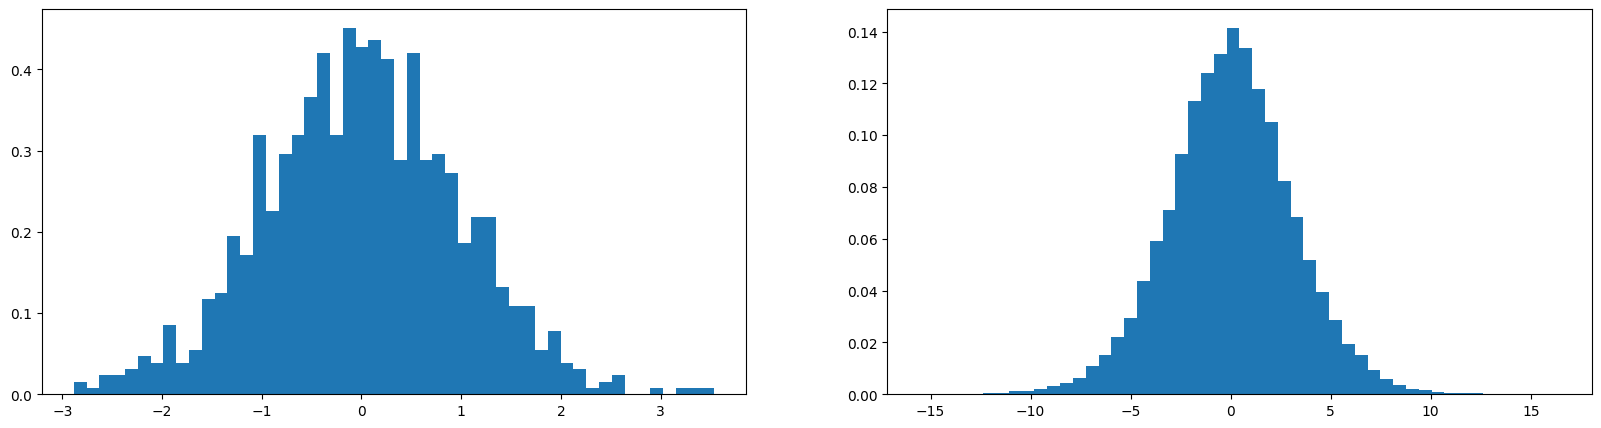

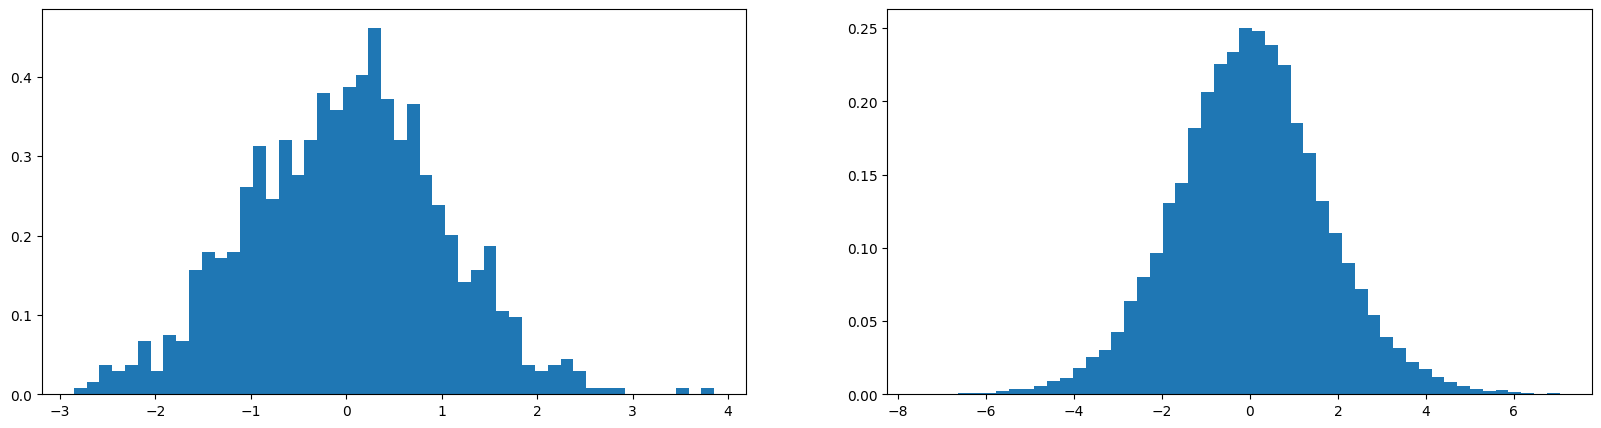

In [10]:
x = torch.randn((100, 10))   # gaussain distribution
w = torch.randn((10, 200))   # gaussian distribution 
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# We can see that our std deviation is getting increased the weights are making our inputs spread more 
# Solution 
x = torch.randn((100, 10))   
w = torch.randn((10, 200)) * (5/3) / (10**0.5) # gain / square root of inputs (fan_in)
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

**Batch Normalization: A Trade-off Between Stability and Complexity**  

Batch Normalization (BN) significantly improves the stability of neural network training, but it introduces a unique side effect.  

Traditionally, when processing a single input example, the neural network’s activations and logits are computed deterministically.  
However, for efficiency, we started processing multiple examples in batches.  
Initially, this was purely for computational optimization, with each example being processed independently within a batch.  

With Batch Normalization, however, this independence is lost.   
Since normalization is performed across an entire batch, the activations of a single example are influenced by all other examples in the same batch.  
This means that the hidden state activations and logits for any given input are no longer solely dependent on that specific input  
but also on the other randomly sampled examples in the batch.  

As a result, the activations fluctuate slightly based on which examples are included in a batch.  
This introduces a form of randomness or **“jitter”** in the network’s computations.  
Interestingly, this jitter acts as an implicit **regularization mechanism**.  
Since the input activations are slightly perturbed based on the batch composition,  
the model becomes less likely to overfit to specific examples.  

This effect is somewhat similar to **data augmentation**—it introduces small variations that make the network more robust and generalizable.  
By preventing the model from locking onto exact patterns in individual samples,  
Batch Normalization indirectly encourages better generalization and stability during training.  

**Input:** Values of $x$ over a mini-batch: $\mathcal{B} = \{x_1, ..., x_m\}$  
Parameters to be learned: $\gamma, \beta$  

**Output:** $\{ y_i = BN_{\gamma, \beta} (x_i) \}$

$$
\mu_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i
\quad \quad // \text{mini-batch mean}
$$

$$
\sigma^2_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_{\mathcal{B}})^2
\quad \quad // \text{mini-batch variance}
$$

$$
\hat{x}_i \leftarrow \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma^2_{\mathcal{B}} + \epsilon}}
\quad \quad // \text{normalize}
$$

$$
y_i \leftarrow \gamma \hat{x}_i + \beta \equiv BN_{\gamma, \beta} (x_i)
\quad \quad // \text{scale and shift}
$$

$\epsilon$: : this is used to prevent division by zero

**Algorithm 1:** Batch Normalizing Transform, applied to activation $x$ over a mini-batch.


In [19]:
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(SEED)


for i in range(max_steps):

    # min batch 
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # first layer 
    emb = C[Xb] # embed the characters into vector
    embcat = emb.view(emb.shape[0], -1) # concatenate the vector

    # hidden layer 
    # we don't want the pre-activation hidden layer output to be too small because than tanh is not doing anything 
    # and we also don't want it to be large because then tanh will be too saturated and gradient will not flow we want them to be roughly gaussian 
    # 0 mean 1 std at least at intiallization so to do it just take the hidden state and normalizie them to be gaussian 
    # and we can do it because standarizing hidden state to gaussian is a perfectly defrential operation

    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

    # batch normalization
    #--------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias 

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #--------------------------------------------------------
    
    h = torch.tanh(hpreact) # hidden layer
    # third layer
    logits = h @ W2 + b2
    
    # loss 
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

    #break

      0/ 200000: 3.2934


  10000/ 200000: 2.0778
  20000/ 200000: 2.3837
  30000/ 200000: 2.0879
  40000/ 200000: 2.0825
  50000/ 200000: 2.3614
  60000/ 200000: 1.9799
  70000/ 200000: 2.0874
  80000/ 200000: 2.2524
  90000/ 200000: 2.0369
 100000/ 200000: 2.1774
 110000/ 200000: 2.0857
 120000/ 200000: 2.2021
 130000/ 200000: 1.6541
 140000/ 200000: 2.2542
 150000/ 200000: 2.2939
 160000/ 200000: 2.0654
 170000/ 200000: 1.7312
 180000/ 200000: 2.6494
 190000/ 200000: 2.3399


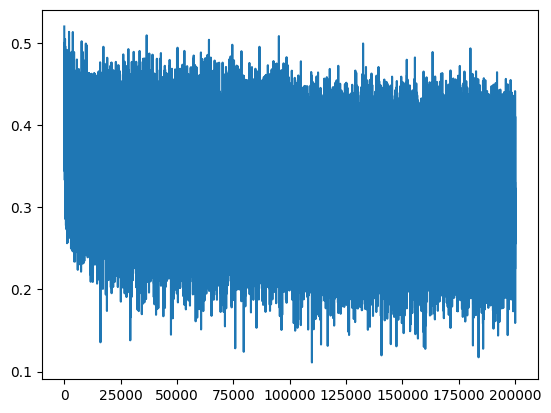

In [12]:
plt.plot(lossi)

In [ ]:
# Another issue is our h 
h
# here we can se that lots of our value are 1, and -1 

tensor([[ 0.8810,  0.9433, -0.9320,  ..., -0.3988, -0.7453,  0.9005],
        [ 0.9489, -0.2966,  0.9102,  ..., -0.9576,  0.8927,  0.8414],
        [-0.0379, -0.9135,  0.2614,  ...,  0.9588, -0.9629,  0.5953],
        ...,
        [ 0.6236, -0.8190, -0.7018,  ...,  0.9079, -0.2305,  0.7248],
        [-0.7979, -0.5701,  0.5447,  ...,  0.0389, -0.9189,  0.3591],
        [ 0.9664,  0.0152,  0.4079,  ..., -0.9992,  0.9768,  0.5741]],
       grad_fn=<TanhBackward0>)

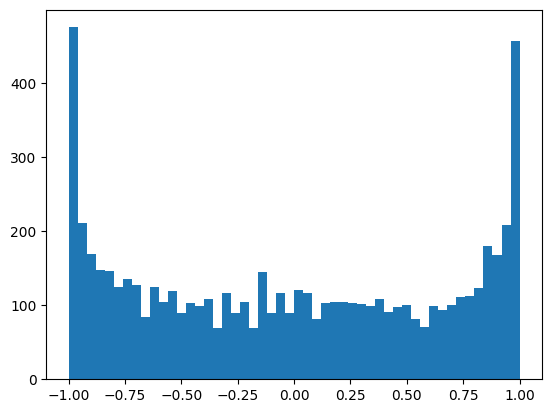

In [14]:
plt.hist(h.view(-1).tolist(), bins=50);
# most of our values are 1 or -1 this is because torch.tanh squash the value between -1 and 1 

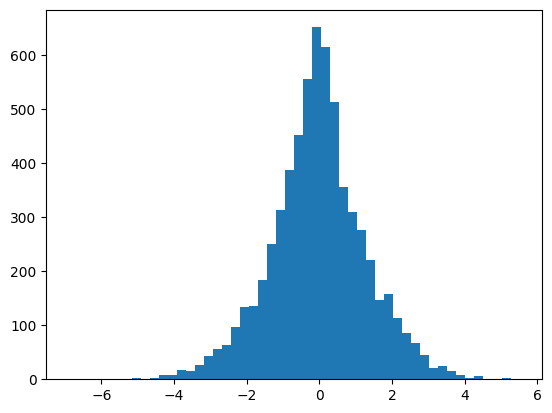

In [15]:
plt.hist(hpreact.view(-1).tolist(), 50);
# our values are spread bewteen -20 to 20 so a lots of values are getting squashed into -1 and 1 
# why this is a problem because of backpropagation 


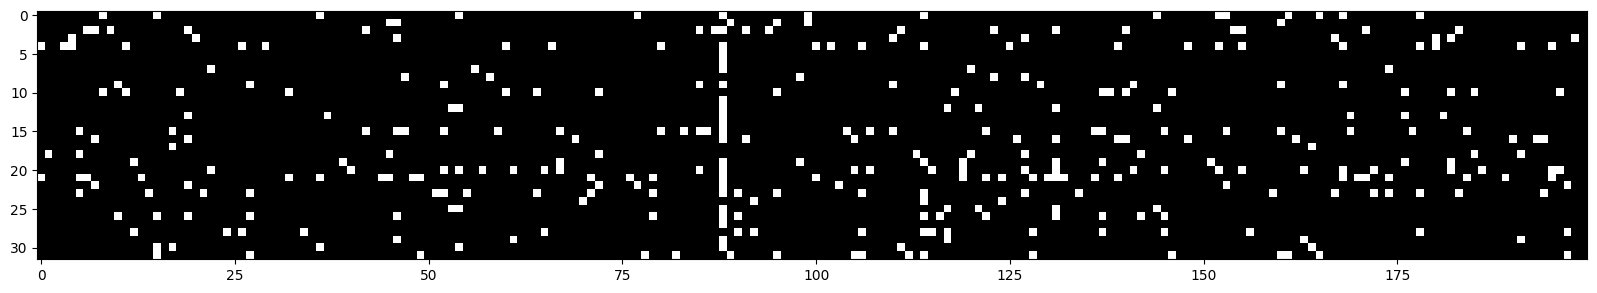

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')
# what we are doing in this plot is we are checking how offen our values are above 0.99 
# this is a boolean map and white tiles shows true and grey shows false
# observation : most of the values are greater than 0.99 


# we will be in lot of trouble if anyone of the entire column would be white in that case we will have a dead neuron 
# in such a case the intiallization of weight and biases could be such that no single example ever activates this tanh in sort of active part of tanh 
# if all the examples land in the tail then this neuron will never learn it is a dead neuron


**How to calculate loss on dev and test or in prod with batch normalization** 
Once we have trained our neural network then we want to deploy it to some kind of setting and we'd like to be able to feed in a single individual example and get a prediction out from our neural network but how do we do that when our neural net now in a forward pass estimates the statistics of mean and std of a batch. The neural net expects batches of input now so how do we feed in a single example and get sensible results our and so the proposal in the batch normalization paper is the following what we would like to do here is we would like to basically have a step after tariing that calcualtes and set the batch mean and std a single time over the training set 

`with torch.no_grad():
    # pass the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire datset
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
`


and at test time we are going to fix these and use them during inference 
no body wants to calculate bnmean and bnstd seperately so we do it with our trianing only 

In [14]:
with torch.no_grad():
    # pass the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire datset
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [15]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': [Xtr, Ytr],
        'dev' : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # bnmeani = hpreact.mean(0, keepdim=True)
    # bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

train 2.0679237842559814
dev 2.109525442123413
test 2.1098077297210693
